<a href="https://colab.research.google.com/github/ShravanCool/Captchurer/blob/master/Captchurer_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip generated_captcha_images.zip

In [ ]:
!unzip extracted_letter_images.zip

In [4]:
import imutils
import cv2


def resize_to_fit(image, width, height):
    """
    A helper function to resize an image to fit within a given size
    :param image: image to resize
    :param width: desired width in pixels
    :param height: desired height in pixels
    :return: the resized image
    """

    # grab the dimensions of the image, then initialize
    # the padding values
    (h, w) = image.shape[:2]

    # if the width is greater than the height then resize along
    # the width
    if w > h:
        image = imutils.resize(image, width=width)

    # otherwise, the height is greater than the width so resize
    # along the height
    else:
        image = imutils.resize(image, height=height)

    # determine the padding values for the width and height to
    # obtain the target dimensions
    padW = int((width - image.shape[1]) / 2.0)
    padH = int((height - image.shape[0]) / 2.0)

    # pad the image then apply one more resizing to handle any
    # rounding issues
    image = cv2.copyMakeBorder(image, padH, padH, padW, padW,
        cv2.BORDER_REPLICATE)
    image = cv2.resize(image, (width, height))

    # return the pre-processed image
    return image

In [63]:
import cv2
import pickle
import os.path
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# from helpers import resize_to_fit


LETTER_IMAGES_FOLDER = "extracted_letter_images"
MODEL_FILENAME = "captcha_random_forest.hdf5"
MODEL_LABELS_FILENAME = "model_labels_rf.dat"


# initialize the data and labels
data = []
labels = []

# loop over the input images
for image_file in paths.list_images(LETTER_IMAGES_FOLDER):
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize the letter so it fits in a 20x20 pixel box
    image = resize_to_fit(image, 20, 20)

    # Add a third channel dimension to the image to make Keras happy
    # image = np.expand_dims(image, axis=2)

    # Grab the name of the letter based on the folder it was in
    label = image_file.split(os.path.sep)[-2]

    # Add the letter image and it's label to our training data
    data.append(image)
    labels.append(label)


# scale the raw pixel intensities to the range [0, 1] (this improves training)
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

nsamples, nx, ny = data.shape
data = data.reshape((nsamples,nx*ny))

# Split the training data into separate train and test sets
(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels, test_size=0.25, random_state=0)

# Convert the labels (letters) into one-hot encodings that Keras can work with
# lb = LabelBinarizer().fit(Y_train)
# Y_train = lb.transform(Y_train)
# Y_test = lb.transform(Y_test)

# Save the mapping from labels to one-hot encodings.
# We'll need this later when we use the model to decode what it's predictions mean
with open(MODEL_LABELS_FILENAME, "wb") as f:
    pickle.dump(lb, f)

clf = RandomForestClassifier()
clf.fit(X_train, Y_train)

Y_pred = clf.predict(X_test)

print("Accuracy score-", accuracy_score(Y_test, Y_pred))

pickle.dump(clf, open(MODEL_FILENAME, 'wb'))

Accuracy score- 0.9935990088787942


In [64]:
Y_pred

array(['Z', 'J', 'Z', ..., '9', 'P', 'N'], dtype='<U1')

In [65]:
Y_test

array(['Z', 'J', 'Z', ..., '9', 'P', 'N'], dtype='<U1')

CAPTCHA text is: DGA6


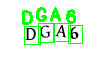

CAPTCHA text is: EZEB


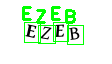

CAPTCHA text is: SSE2


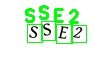

CAPTCHA text is: E8UH


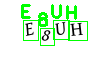

CAPTCHA text is: Q74J


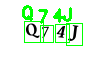

CAPTCHA text is: 8E9N


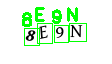

CAPTCHA text is: YDT5


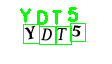

CAPTCHA text is: 5WRQ


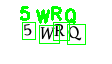

CAPTCHA text is: 77KS


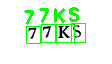

CAPTCHA text is: QE7C


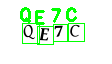

In [73]:
from keras.models import load_model
# from helpers import resize_to_fit
from imutils import paths
import numpy as np
import imutils
import cv2
import pickle
from google.colab.patches import cv2_imshow


MODEL_FILENAME = "captcha_random_forest.hdf5"
MODEL_LABELS_FILENAME = "model_labels_rf.dat"
CAPTCHA_IMAGE_FOLDER = "generated_captcha_images"


# Load up the model labels (so we can translate model predictions to actual letters)
with open(MODEL_LABELS_FILENAME, "rb") as f:
    lb = pickle.load(f)

# Load the trained neural network
# model = pickle.load(open(MODEL_FILENAME, 'rb'))
model = load_model(MODEL_FILENAME)

# Grab some random CAPTCHA images to test against.
# In the real world, you'd replace this section with code to grab a real
# CAPTCHA image from a live website.
captcha_image_files = list(paths.list_images(CAPTCHA_IMAGE_FOLDER))
captcha_image_files = np.random.choice(captcha_image_files, size=(10,), replace=False)

# loop over the image paths
for image_file in captcha_image_files:
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Add some extra padding around the image
    image = cv2.copyMakeBorder(image, 20, 20, 20, 20, cv2.BORDER_REPLICATE)

    # threshold the image (convert it to pure black and white)
    thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    # find the contours (continuous blobs of pixels) the image
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Hack for compatibility with different OpenCV versions
    contours = contours[1] if imutils.is_cv3() else contours[0]

    letter_image_regions = []

    # Now we can loop through each of the four contours and extract the letter
    # inside of each one
    for contour in contours:
        # Get the rectangle that contains the contour
        (x, y, w, h) = cv2.boundingRect(contour)

        # Compare the width and height of the contour to detect letters that
        # are conjoined into one chunk
        if w / h > 1.25:
            # This contour is too wide to be a single letter!
            # Split it in half into two letter regions!
            half_width = int(w / 2)
            letter_image_regions.append((x, y, half_width, h))
            letter_image_regions.append((x + half_width, y, half_width, h))
        else:
            # This is a normal letter by itself
            letter_image_regions.append((x, y, w, h))

    # If we found more or less than 4 letters in the captcha, our letter extraction
    # didn't work correcly. Skip the image instead of saving bad training data!
    if len(letter_image_regions) != 4:
        continue

    # Sort the detected letter images based on the x coordinate to make sure
    # we are processing them from left-to-right so we match the right image
    # with the right letter
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

    # Create an output image and a list to hold our predicted letters
    output = cv2.merge([image] * 3)
    predictions = []

    # loop over the lektters
    for letter_bounding_box in letter_image_regions:
        # Grab the coordinates of the letter in the image
        x, y, w, h = letter_bounding_box

        # Extract the letter from the original image with a 2-pixel margin around the edge
        letter_image = image[y - 2:y + h + 2, x - 2:x + w + 2]

        # Re-size the letter image to 20x20 pixels to match training data
        letter_image = resize_to_fit(letter_image, 20, 20)
        # print(letter_image)

        letter_image = np.expand_dims(letter_image, axis=2)
        letter_image = np.expand_dims(letter_image, axis=0)

        # nx, ny = letter_image.shape
        # letter_image = letter_image.reshape(nx*ny)
        # letter_image = letter_image.reshape(1, -1)

        # Ask the neural network to make a prediction
        prediction = model.predict(letter_image)
        # print(prediction)

        # Convert the one-hot-encoded prediction back to a normal letter
        letter = lb.inverse_transform(prediction)[0]
        predictions.append(letter)

        # draw the prediction on the output image
        cv2.rectangle(output, (x - 2, y - 2), (x + w + 4, y + h + 4), (0, 255, 0), 1)
        cv2.putText(output, letter, (x - 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0, 255, 0), 2)

    # Print the captcha's text
    captcha_text = "".join(predictions)
    print("CAPTCHA text is: {}".format(captcha_text))

    # Show the annotated image
    cv2_imshow(output)
    cv2.waitKey()